# 3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:
а) навчить мережу і embedding шар з нуля (from scratch)
б) використовуючи pretrained word embeddings
 Результати порівняйте між собою і з одержаними раніш. 
Приклади:
https://github.com/natsakh/Data-Analysis/tree/main/Pr_7
https://keras.io/examples/nlp/text_classification_from_scratch/
https://keras.io/examples/nlp/bidirectional_lstm_imdb/
https://keras.io/examples/nlp/pretrained_word_embeddings/
* у деяких прикладах, з наведених вище, вирішується задача класифікації текстів за допомогою згорткових мереж, але вони можуть бути використані як приклад препроцесінга

б) використовуючи pretrained word embeddings

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [43]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 100 # max length of each text (in terms of number of words)
embedding_dim = 100 # dimension of word embeddings
lstm_units = 128 # number of units in the LSTM layer
num_classes = 2 # number of classes

In [44]:
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [45]:
data_train = []
with open("../Lab_2/archive/test.ft.txt", "rt") as file:
    for line in file:
        data_train.append(line.split(" ", 1))

df_train = pd.DataFrame(np.array(data_train), columns=['target', 'text'])

df_train.head()

,target,text
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [46]:
data_test = []
with open("../Lab_2/archive/test.ft.txt", "rt") as file:
    for line in file:
        data_test.append(line.split(" ", 1))

df_test = pd.DataFrame(np.array(data_test), columns=['target', 'text'])

df_test.head()

,target,text
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [47]:
def target_to_numeric(df):
	for i in range(len(df)):
		if df.loc[i, "target"] == "__label__1":
			df.loc[i, "target"] = 0
		else:
			df.loc[i, "target"] = 1

target_to_numeric(df_train)
target_to_numeric(df_test)

In [48]:
texts = df_train["text"]
labels = df_train["target"]

In [65]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(texts).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()[:5]

['', '[UNK]', np.str_('the'), np.str_('i'), np.str_('and')]


In [74]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [75]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [76]:
# num_tokens = len(voc) + 2
# embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2120 words (175 misses)


In [77]:
# embedding_layer = Embedding(
#     num_tokens,
#     embedding_dim,
#     trainable=False,
# )
# embedding_layer.build((1,))
# embedding_layer.set_weights([embedding_matrix])

In [113]:
x = pad_sequences(sequences, maxlen=max_len)
y = keras.utils.to_categorical(labels, num_classes)

model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
	layers.Conv1D(max_len, 2, activation="relu"),
	layers.MaxPooling1D(),
	layers.Conv1D(max_len, 2, activation="relu"),
	layers.MaxPooling1D(),
	layers.Conv1D(max_len, 2, activation="relu"),
	layers.GlobalMaxPooling1D(),
	layers.Dense(max_len, activation="relu"),
	layers.Dropout(0.5),
	Dense(num_classes, activation='softmax')
])



model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])


# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# class_weight_dict = dict(enumerate(class_weights))

history = model.fit(x, y, batch_size=32, epochs=10, validation_split=0.02)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.4640 - loss: 0.7459 - val_accuracy: 1.0000 - val_loss: 0.6441
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5207 - loss: 0.6873 - val_accuracy: 1.0000 - val_loss: 0.6471
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5960 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.6587
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5963 - loss: 0.6772 - val_accuracy: 0.5000 - val_loss: 0.6565
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5898 - loss: 0.6748 - val_accuracy: 1.0000 - val_loss: 0.6570
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6167 - loss: 0.6578 - val_accuracy: 1.0000 - val_loss: 0.6572
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6268 - loss: 0.6679 - val_accuracy: 1.0000 - val_loss: 0.6480
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7481 - loss: 0.6284 - val_accuracy: 1.0000 - val_loss: 0.6510


In [114]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

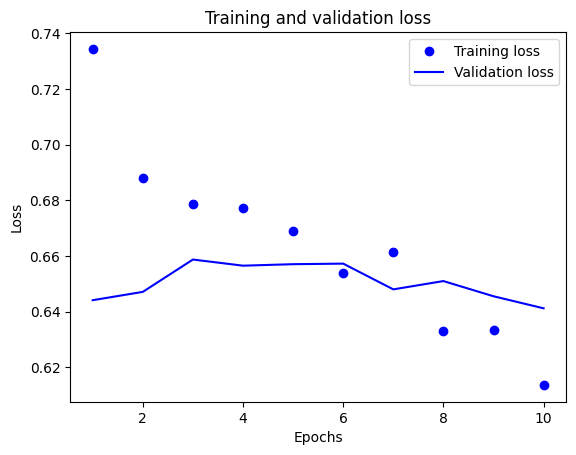

In [115]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [116]:
texts_train = df_test["text"]
labels_train = df_test["target"]

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)


x_test = pad_sequences(sequences_train, maxlen=max_len)
y_test = keras.utils.to_categorical(labels_train, num_classes)

In [117]:
score = model.evaluate(x_test, y_test, verbose=1) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9202 - loss: 0.6095
Test score: 0.6099059581756592
Test accuracy: 0.9100000262260437
